## Import packages

In [1]:
using Pkg
Pkg.add("Random")

Pkg.add("MLJ")

Pkg.add("CSV")
Pkg.add("DataFrames")

Pkg.add("MultivariateStats")
Pkg.add("ScikitLearn")

Pkg.add("Plots")
Pkg.add("Measures")

using Random

using MLJ:partition

using CSV
using DataFrames

using MultivariateStats
using ScikitLearn

using Plots
using Measures

## Read data

We choose the column "Cancer Stage", labeled 1 through 4 in roman numerals, to be the class predicted. We remove this column and save it to Y. For the rest of the data, we find all string variables and encode into integers. We then convert to floats and divide by the maximum value to scale each column from 0 to 1.

In [2]:
# The string based categorical types are:
# FamilHx, SmokingHx,Sex, Cancer Stage, School
data = CSV.File("01_hdp.csv", header = true) |> DataFrame

# LET'S ASSSSUUUMMMMME that the Y data is cancer stage
Y = convert(Array, copy(data.CancerStage))
df = select(data, Not(:CancerStage))

# Proceed with encoding feature data. . . .

# Get vector that contains the data type for each column
types = eltype.(eachcol(df))

# Indices of the columns that contain string variables
ind = findall(x -> x == String, types)

# convert the dataframe to an array
df = convert(Array, df)

# for every column with a string, reassign to integer values based on number of labels
# then convert it to a float, and divide by max to scale from 0 to 1
for colInd in ind
    col = df[:, colInd]
    labels = sort(unique(col))

    for i in 1:length(labels)
        col[col .== labels[i]] .= "$(i-1)"
    end    

    col = parse.(Float64, col)
    
    # Divide by max to convert from 0 to 1 scale
    col  = col ./  findmax(col)[1]
    
    df[:, colInd] = col
    
end

# Scale the non-string columns by the max
for i in 1:size(df, 2)
    if i in ind
        continue
    end
    
    df[:, i] = df[:, i] ./ findmax(df[:, i])[1]
end

# Convert to a float matrix
df = convert(Array{Float64, 2}, df)

8525×26 Array{Float64,2}:
 0.58374   0.720983  0.444444  …  0.0  0.333333  0.0285714  0.740008
 0.555587  0.787615  0.222222     0.0  0.333333  0.0285714  0.740008
 0.442795  0.720566  0.666667     0.0  0.333333  0.0285714  0.740008
 0.742225  0.682906  0.333333     0.0  0.333333  0.0285714  0.740008
 0.458536  0.736027  0.333333     0.0  0.333333  0.0285714  0.740008
 0.44357   0.666256  0.444444  …  0.0  0.333333  0.0285714  0.740008
 0.677645  0.801947  0.333333     0.0  0.333333  0.0285714  0.740008
 0.599644  0.718348  0.333333     0.0  0.333333  0.0285714  0.740008
 0.539702  0.725038  0.444444     0.0  0.333333  0.0285714  0.740008
 0.616342  0.748581  0.555556     0.0  0.333333  0.0285714  0.740008
 0.566948  0.75624   0.444444  …  0.0  0.333333  0.0285714  0.740008
 0.493919  0.768006  0.444444     0.0  0.333333  0.0285714  0.740008
 0.419374  0.721614  0.555556     0.0  0.333333  0.0285714  0.740008
 ⋮                             ⋱                            ⋮
 0.659156  0.71

## Get training and testing subsets

We shuffle indices into two mutually exclusive sets containing the rows for the train and test sets. We then acquire these sets by using the data and subsetting by those indices. We also acquire the transpose of the data for use in PCA, which mandates that matrices be $ d \times n $, where $d$ is the dimension of an obversation and $n$ is the number of observations.


In [3]:
# train and test subset indices
train, test = partition(1:8525, 0.70, shuffle = true)

# Get the subsets
trainX = df[train, :]
trainY = vec(Y[train, :])

testX = df[test, :]
testY = vec(Y[test, :])

# Grab transpose for PCA
df_T = collect(transpose(df))
trainX_T = collect(transpose(trainX))
testX_T = collect(transpose(testX))

df_T

26×8525 Array{Float64,2}:
 0.58374    0.555587   0.442795   0.742225   …  0.576157  0.570021  0.566069
 0.720983   0.787615   0.720566   0.682906      0.710698  0.760575  0.745971
 0.444444   0.222222   0.666667   0.333333      0.555556  0.777778  0.444444
 0.444444   0.333333   0.333333   0.333333      0.666667  0.555556  0.555556
 0.222222   0.222222   0.222222   0.222222      0.444444  0.333333  0.333333
 0.0        0.0        0.0        0.0        …  0.0       0.333333  0.111111
 0.0        0.0        0.0        0.0           0.222222  0.111111  0.111111
 0.0        0.0        0.0        0.0           1.0       1.0       1.0
 0.801252   0.326511   0.565146   0.848584      0.79733   0.969831  0.911855
 0.872264   0.723891   0.716241   0.555407      0.675553  0.766891  0.75274
 0.0        0.0        1.0        0.0        …  0.0       0.0       0.0
 0.0        0.0        0.0        0.0           0.0       0.0       0.0
 0.5        0.5        1.0        0.5           0.5       1.0     

## Performing PCA

We use the transpose data to fit a PCA to a model, then use the model to transform the data.  Then it is transposed to restore the data to $n \times d$ form to extract the training and test subsets to feed into the ML models.

In [4]:
# Create model based on full observations
M = MultivariateStats.fit(PCA, df_T, maxoutdim = 5)

# Transform the given observations
reducedDF_T = MultivariateStats.transform(M, df_T)
reducedDF = collect(transpose(reducedDF_T))

reducedTrain = reducedDF[train, :]
reducedTest = reducedDF[test, :]

2557×5 Array{Float64,2}:
 -0.486618   -0.175069   -0.91865     -0.493254   -0.202747
 -0.0938954   0.676603   -0.56409     -0.0451235  -0.0745602
 -0.0812916   0.375783   -0.00585679   0.472862    0.49176
  0.390966   -0.859832    0.387409     0.4691     -0.664939
  0.0754071  -0.661243    0.164958    -0.258769    0.0535508
 -0.337349    0.410909    0.216255     0.711797   -0.494335
  0.112441    0.640192   -0.570978     0.240484   -0.738865
 -0.974582    0.361412    0.569286    -0.589722    0.253187
 -0.0155439   0.443486   -0.0898745    0.29053     0.51343
 -0.153154    0.347203    0.232359     0.819107   -0.399841
 -0.0448634   0.761743   -0.686319    -0.26307    -0.0477382
  0.276394    0.0513842   0.872531    -0.702937    0.334109
 -0.25686     0.505118   -0.0464473    0.0394697   0.406243
  ⋮                                               
  0.756482   -0.536973   -0.592924    -0.339138   -0.0829853
  0.246872    0.255824    0.502488    -0.253581    0.186966
 -0.253694    0.459464

## Machine Learning Models

We just do a single case, using a Support Vector Classifier, with the above PCA model and look at the accuracy. It is reported to be greater than 0.25, which is the bare minimum if one were to guess the entire time.

In [5]:
# Model
@sk_import svm : SVC
bayes_model = SVC()

# Training and evaluation
fit!(bayes_model, reducedTrain, trainY)

accuracy = sum(ScikitLearn.predict(bayes_model, reducedTest) .== testY) / length(testY)

println("Proportion correct: ", accuracy)

Proportion correct: 0.47946812671098943


## Functions to Automate Tests

We create functions that will allow us to automate the PCA and modeling process using a variety of machine learning models. Using this we will also graph the results.

The first function will perofrm an individual test given the desired dimensions of the PCA, train a model, then get the accuracy.

The next function will call multiple of these tests then compile the results. It will display both the accuracy and time taken. If PCA produced the same amount of dimensions for a given input, further iterations will be cut off on the graph.


In [6]:
# n is number of dimensions we want from pca
function performTest(n, model, df_T)
    # Perform PCA
    M = MultivariateStats.fit(PCA, df_T, maxoutdim = n)

    # Transform the dataframe
    reducedDF_T = MultivariateStats.transform(M, df_T)

    # transpose it to get the original dimensions
    reducedDF = collect(transpose(reducedDF_T))
    
    
    # Extract the training and test subsets
    reducedTrain = reducedDF[train, :]
    reducedTest = reducedDF[test, :]

    # Train the model and report the accuracy
    ScikitLearn.fit!(model, reducedTrain, trainY)
    accuracy = sum(ScikitLearn.predict(model, reducedTest) .== testY) / length(testY)
    
    return (accuracy, size(reducedDF, 2))
    
end


function testResulter(model, df_T, model_name)
    # Empty lists of results, times, and maximum n values from PCA
    results = []
    times = []
    nList = []
    
    # Save the graphical layout to display side by side
    L = @layout [a b]

    # Iterate through each possible dimension and perform the test
    for n in 1:26
        t1 = time()
        res, nIter = performTest(n, ml_model, df_T)
        t2 = time()
   
    
        push!(results, res)
        push!(times, t2 - t1)
        push!(nList, nIter)
    end
    
    # Report the accuracy at N = 7, which is where many models have a jump in accuracy
    print("Accuracy at N = 7: $(round(results[7], digits = 4))")

    # Store the max N as well as the appopriate accuracy and time results
    maxN = maximum(nList)
    resultsRed = results[1:maxN]
    timesRed = times[1:maxN]

    # Create the accuracy plot
    accPlot = scatter(1:maxN, resultsRed, title = "Accuracy by Dim in PCA using $(model_name)", xlim = (0, 27), ylim = (0.20, 0.70), 
        legend = false, xlabel = "Number of Dimensions", ylabel = "Proportion of Predictions Correct")

    # Create the time plot
    timePlot = scatter(1:maxN, timesRed, title = "Time taken by PCA + Modeling by Dim", xlim = (0, 27), ylim = (0.0, 0.5),
        legend = false, xlabel = "Number of Dimensions", ylabel = "Seconds")

    # Display the two plots
    plot(accPlot, timePlot, layout = L, margin = 10mm, size = (800, 400))
    
end



testResulter (generic function with 1 method)

## Performing the Tests

We now perform the tests on a variety of machine learning models.

Accuracy at N = 7: 0.5084

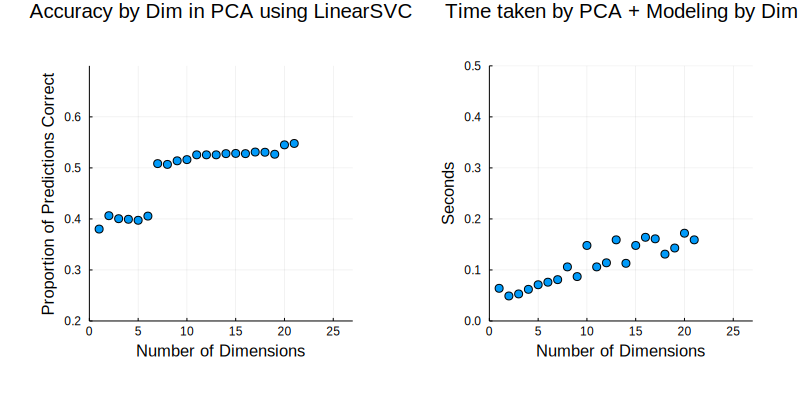

In [7]:
@sk_import svm : LinearSVC
ml_model = LinearSVC()

testResulter(ml_model, df_T, "LinearSVC")

Accuracy at N = 7: 0.4192

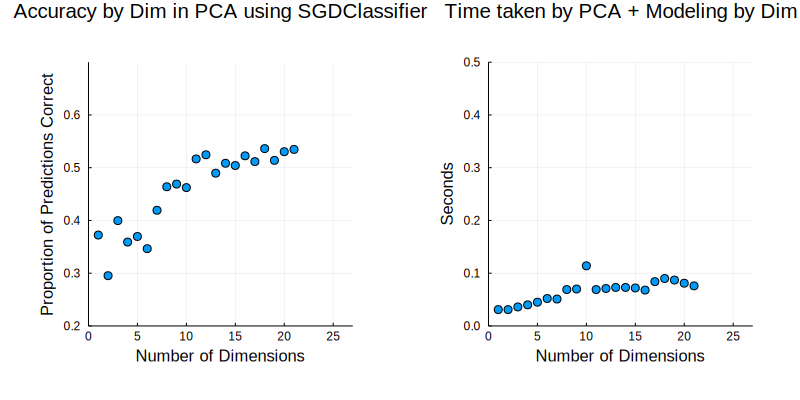

In [8]:
@sk_import linear_model : SGDClassifier
ml_model = SGDClassifier()

testResulter(ml_model, df_T, "SGDClassifier")

Accuracy at N = 7: 0.4235

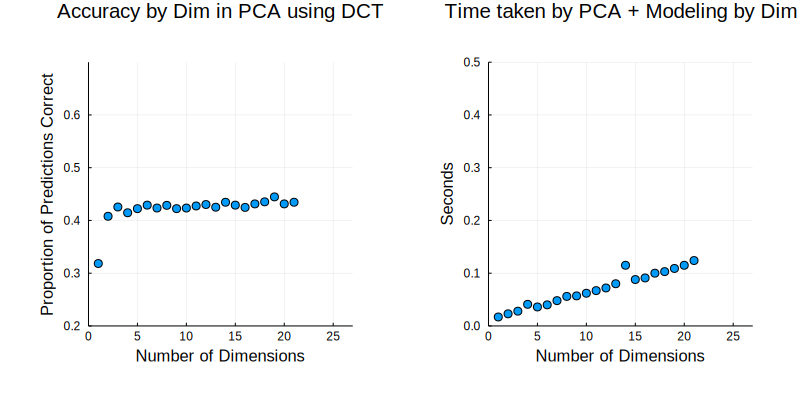

In [9]:
@sk_import tree : DecisionTreeClassifier
ml_model = DecisionTreeClassifier()

testResulter(ml_model, df_T, "DCT")

Accuracy at N = 7: 0.501

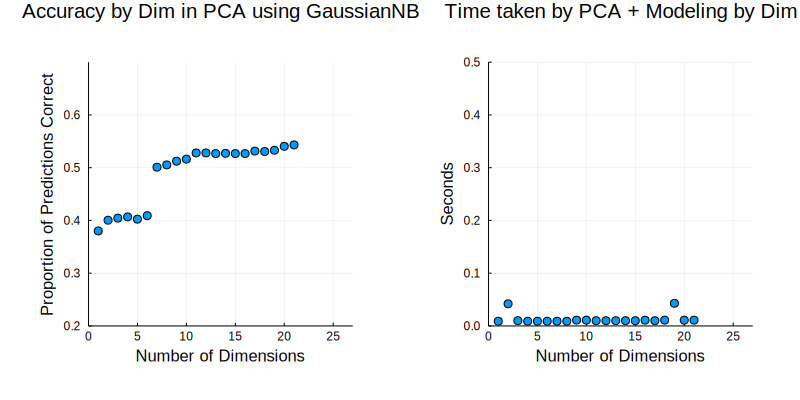

In [10]:
@sk_import naive_bayes : GaussianNB
ml_model = GaussianNB()

testResulter(ml_model, df_T, "GaussianNB")

Accuracy at N = 7: 0.5213

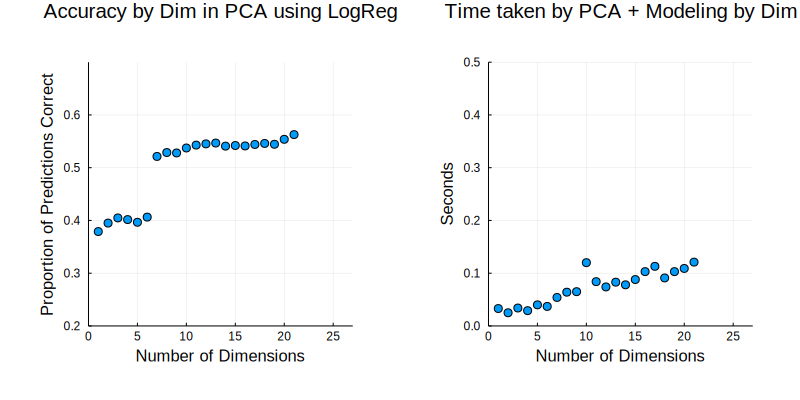

In [11]:
@sk_import linear_model : LogisticRegression
ml_model = LogisticRegression()

testResulter(ml_model, df_T, "LogReg")

We note that the LinearSVC, GaussianNB, and LogisticRegression models have the highest accuracy. We may favor the GaussianNB model for its generally high accuracy as well as having the shortest run time.